In [1]:
%pip install torch
%pip install torchvision


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.6/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.6/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


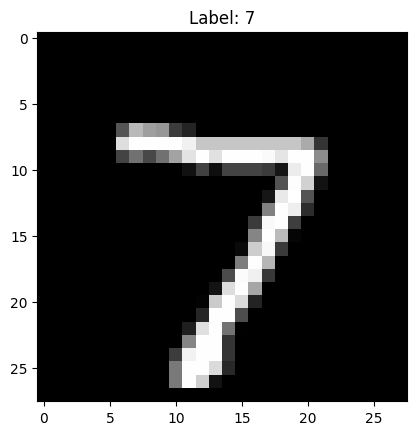

In [5]:
import matplotlib.pyplot as plt
def show_image(image, label):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()
show_image(X[0], y[0])

In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [7]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [15]:
list(model.linear_relu_stack[0].parameters())

[Parameter containing:
 tensor([[-0.0014,  0.0336,  0.0182,  ..., -0.0318, -0.0343, -0.0282],
         [-0.0036, -0.0323, -0.0093,  ..., -0.0015, -0.0115, -0.0050],
         [ 0.0131,  0.0263, -0.0080,  ...,  0.0056, -0.0090,  0.0225],
         ...,
         [ 0.0236,  0.0344,  0.0041,  ...,  0.0132, -0.0329, -0.0338],
         [ 0.0320,  0.0177, -0.0015,  ..., -0.0104, -0.0307, -0.0196],
         [-0.0234, -0.0330, -0.0115,  ...,  0.0228, -0.0003, -0.0114]],
        requires_grad=True),
 Parameter containing:
 tensor([-1.3600e-02,  1.1864e-02,  5.4885e-03, -1.6902e-02,  1.9671e-02,
          4.2862e-03,  3.2405e-02, -5.9072e-03, -2.6209e-02, -4.5827e-03,
          2.7865e-02,  2.9302e-02, -1.1871e-02,  3.3054e-02, -1.0095e-02,
         -6.4868e-03, -3.0558e-02, -1.2347e-02,  1.2729e-02, -2.5318e-03,
         -3.1488e-02, -3.5054e-02, -1.1316e-02,  1.0828e-02,  3.6050e-02,
          2.4025e-02,  2.1746e-02, -4.0943e-03, -1.0703e-02,  2.7580e-03,
         -1.7887e-02,  5.5075e-03, -1.86

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
import time
start = time.time()
epochs = 5
test(test_dataloader, model, loss_fn)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done in ", time.time() - start, " seconds")

Test Error: 
 Accuracy: 11.9%, Avg loss: 2.315746 

Epoch 1
-------------------------------
loss: 2.320072  [   64/60000]
loss: 2.281309  [ 6464/60000]
loss: 2.270785  [12864/60000]
loss: 2.220879  [19264/60000]
loss: 2.213635  [25664/60000]
loss: 2.202037  [32064/60000]
loss: 2.129568  [38464/60000]
loss: 2.146335  [44864/60000]
loss: 2.097662  [51264/60000]
loss: 2.075108  [57664/60000]
Test Error: 
 Accuracy: 64.7%, Avg loss: 2.051794 

Epoch 2
-------------------------------
loss: 2.059916  [   64/60000]
loss: 2.008694  [ 6464/60000]
loss: 2.020241  [12864/60000]
loss: 1.905036  [19264/60000]
loss: 1.925415  [25664/60000]
loss: 1.910556  [32064/60000]
loss: 1.800620  [38464/60000]
loss: 1.871886  [44864/60000]
loss: 1.773053  [51264/60000]
loss: 1.727718  [57664/60000]
Test Error: 
 Accuracy: 72.1%, Avg loss: 1.698042 

Epoch 3
-------------------------------
loss: 1.718040  [   64/60000]
loss: 1.630872  [ 6464/60000]
loss: 1.664411  [12864/60000]
loss: 1.499201  [19264/60000]
loss

In [14]:
preds = model(X[0].to(device))
preds

tensor([[-0.4013, -2.2614, -1.6052, -0.1392,  0.8867, -0.1384, -2.3127,  4.3744,
         -0.4752,  2.1780]], grad_fn=<AddmmBackward0>)

In [13]:
loss_fn(preds[0].to(device), y[0].to(device))

tensor(0.1698, grad_fn=<NllLossBackward0>)